<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Clasificación de Sentimientos con Procesamiento de Lenguaje Natural y Redes Neuronales Recurrentes (LSTM). Corpus en Español sobre restaurantes</h1> </div>

Desarrollado por: Ing. Remigio Hurtado Ortiz, PhD. Correo de contacto: remigiohurtado@gmail.com

En esta práctica aprenderás a clasificar sentimientos en buenos "1" y malos "0" sobre el servicio y platos de comida en restaurantes.  El clasificador se desarrolla mediante procesamiento de lenguaje natural y una red neuronal recurrente de tipo LSTM. Finalmente, aprenderás a presentar los resultados visualmente para una mejor comprensión.

Requisitos: es importante tener conocimientos de Python y de Fundamentos de Machine Learning. Te sugerimos previamente revisar la práctica: <a href="https://genscinet.com/transformacion-clasificacionknn/" target="blank">transformación de variables categóricas y clasificación con KNN</a>.

Esta práctica está estructurada de la siguiente manera:

- [Fase 1: Procesamiento de Lenguaje Natural](#pln)

- [Fase 2: Entrenamiento de red neuronal recurrente](#lstm)

- [Fase 3: Clasificación de nuevos comentarios](#prediccionNuevoElemento)

- [Fase 4: Actualizar conocimiento de la red con nuevo(s) comentario(s)](#re-entrenamiento)

- [Conclusiones](#Conclusiones)

- [Referencias y enlaces](#Referencias-enlaces)

<div id="pln" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Fase 1: Procesamiento de Lenguaje Natural</h2> </div>

Dataset se encuentra en español [1] e incluye un total de 51716 comentarios, 34808 comentarios positivos y 16912 negativos agrupados dentro de los directorios “pos” y “neg”, respectivamente.

In [1]:
import os
from unipath import Path
import pathlib
import pandas as pd
import numpy as np
import copy
import re
import pyprind
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.models import model_from_json
from keras.models import load_model
from pandas import DataFrame

import nltk
nltk.download('stopwords')
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from string import punctuation

import sqlite3
import pickle
print ('********** Módulos importados')

********** Módulos importados


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rhurtadoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rhurtadoo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#FUNCIONES

#stop_words_sp = set(stopwords.words('spanish'))
#stop_words_en = set(stopwords.words('english')) #Concatenar las stopwords aplicándose a una cuenta que genera contenido en inglés y español
#stop_words = stop_words_sp | stop_words_en
#print(stop_words_sp)
def generarStopWords():
    ##Creating a list of stop words and adding custom stopwords
    stop_words = set(stopwords.words('spanish'))
    ##Creating a list of custom stopwords
    new_words = ['ieee','restaurante', 'saboresysalud']
    stop_words = stop_words.union(new_words)
    return stop_words

stop = generarStopWords()
porter = PorterStemmer()

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("à", "a"),
        ("è", "e"),
        ("ì", "i"),
        ("ò", "o"),
        ("ù", "u"),
        #("ñ", "n"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def preprocessor(text):#tokenizer
    #text = re.sub('[^a-zA-z0-9ñ\s]','',text)
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text) #remove tags
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    
    text = normalize(text)#manejo de puntuaciones
    
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in text]).lower()    
    #text=re.sub("(\\d|\\W)+"," ",text) # remove special characters and digits
    ##Stemming
    text = text.split()
    #ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop]#Manejo de stopwords
    tokenized = " ".join(text)
    return tokenized

def guardarRNN(model,nombreArchivoModelo):
    print("Guardando Red Neuronal en Archivo")  
    model.save(nombreArchivoModelo+'.h5')
    print("Red Neuronal Grabada en Archivo")   
    
def cargarRNN(nombreArchivoModelo):
    model = load_model(nombreArchivoModelo+'.h5')  
    print("Red Neuronal Cargada desde Archivo") 
    return model

def guardarTokenizer(tokenizer,nombreArchivoTokenizer):
    with open(nombreArchivoTokenizer+'.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def cargarTokenizer(nombreArchivoTokenizer):
    with open(nombreArchivoTokenizer+'.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    return tokenizer

def RepresentsInt(s):
    try: 
        int(s)
        print(s)
        return True
    except ValueError:
        return False
print('********* Funciones definidas')

********* Funciones definidas


<div id="Importacion" style="color:#106ba3"><h3>Carga de comentarios del dataset</h3> </div>

In [3]:
import json

dirBaseDataset=pathlib.Path().absolute()
dirBaseDatasetPos=str(dirBaseDataset)+"\DatasetSentimientosRestaurante\data\output\pos"
#print(dirBaseDatasetPos)
listaArchivosDatasetPos = os.listdir(dirBaseDatasetPos)
comentarios = []
print("********** Cargando comentarios")
for archivo in listaArchivosDatasetPos:
    dirArchivo=dirBaseDatasetPos+"\\"+archivo
    if os.path.isfile(dirArchivo) and ((archivo.endswith('.json') or archivo.endswith('.JSON'))):
        with open(dirArchivo) as f_in:
            data = json.load(f_in) 
            i=0
            for comentario in data:
                i=i+1
                comentario=" ".join(comentario.split())
                if RepresentsInt(comentario):
                    print(archivo)
                    print(comentario)
                    print(i)
                if comentario == '':
                    print(archivo)
                    print(comentario)
                    print(i)
                comentarios.append([comentario,1])
print("Cantidad de comentarios cargados:",len(comentarios))

dirBaseDataset=pathlib.Path().absolute()
dirBaseDatasetPos=str(dirBaseDataset)+"\DatasetSentimientosRestaurante\data\output\\neg"
#print(dirBaseDatasetPos)
listaArchivosDatasetPos = os.listdir(dirBaseDatasetPos)
for archivo in listaArchivosDatasetPos:
    dirArchivo=dirBaseDatasetPos+"\\"+archivo
    if os.path.isfile(dirArchivo) and ((archivo.endswith('.json') or archivo.endswith('.JSON'))):
        with open(dirArchivo) as f_in:
            data = json.load(f_in) 
            for comentario in data:
                comentario=" ".join(comentario.split())
                comentarios.append([comentario,0])
#print("Cantidad de comentarios cargados:",len(comentarios))
dfOriginal = DataFrame (comentarios,columns=['comentario','sentimiento'])
print('Cantidad total de comentarios cargados:',dfOriginal.shape[0])
dfOriginal.head(10)

********** Cargando comentarios
Cantidad de comentarios cargados: 34804
Cantidad total de comentarios cargados: 51716


,comentario,sentimiento
0,"Ruido infernal, poca luz y muy rica comida. De...",1
1,"Muy buen ambiente, buena música. La atención e...",1
2,"¡Tan bueno como siempre! Después de 15 años, v...",1
3,Me encanta este lugar. Pizza muy finita y riqu...,1
4,Un clásico! Soy habitué desde los 90,1
5,Simplemente genial! Histórico... voy desde que...,1
6,este restaurant es LO MAS ...... desde su dueñ...,1
7,"Ambientaciòn excelente, atenciòn personal y mu...",1
8,Muy buena atmosfera. Atencion agradable. La co...,1
9,Excelente! Siguen siendo el referente de la co...,1


<div style="color:#106ba3"><h3>Análisis de frecuencia de sentimientos</h3> </div>

0 es comentario negativo
1 es comentario positivo


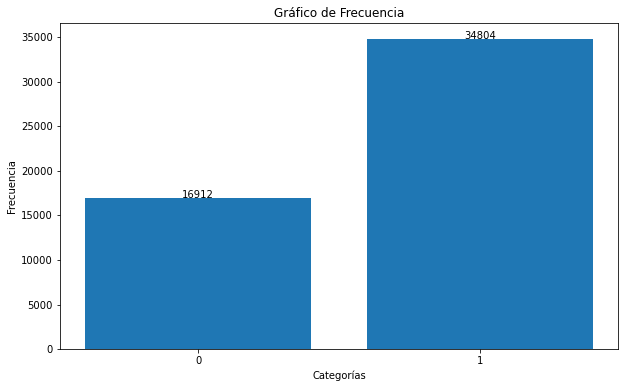

In [4]:
import matplotlib.pyplot as plt
from collections import Counter
Y=dfOriginal['sentimiento'].tolist()
#Y.extend(y_test.tolist()) #para analizar la frecuencia de todo el conjunto de datos

# Utiliza Counter para contar las frecuencias de los elementos en la lista
frecuencias = Counter(Y)

# Separa las claves (elementos) y los valores (frecuencias) en listas separadas
elementos = list(frecuencias.keys())
frecuencias = list(frecuencias.values())

# Aumenta el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crea un gráfico de barras
plt.bar(elementos, frecuencias)

# Etiquetas y título
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Frecuencia')

# Establece las etiquetas del eje X
plt.xticks(elementos)

# Muestra los valores de los elementos en el gráfico
for i, v in enumerate(frecuencias):
    plt.text(elementos[i], v + 0.1, str(v), ha='center')

print('0 es comentario negativo')
print('1 es comentario positivo')
# Muestra el gráfico
plt.show()

<div style="color:#106ba3"><h3>Aplicación de Procesamiento de Lenguaje Natural</h3> </div>

In [5]:
#PREPROCESAMIENTO
dfOriginal['comentario'] = dfOriginal['comentario'].apply(preprocessor)
df=copy.deepcopy(dfOriginal)
df.head(15)

,comentario,sentimiento
0,ruido infernal poca luz rica comida spritz ini...,1
1,buen ambiente buena musica atencion rapida piz...,1
2,tan bueno siempre despues 15 años volvimos fil...,1
3,encanta lugar pizza finita riquisima atencion ...,1
4,clasico habitue 90,1
5,simplemente genial historico voy adolescente t...,1
6,restaurant ma dueño tano inigualable calido ed...,1
7,ambientacion excelente atencion personal buena...,1
8,buena atmosfera atencion agradable comida cali...,1
9,excelente siguen siendo referente cocina itali...,1


<div style="color:#106ba3"><h3>Transformación de lenguaje a números mediante TOKENIZER y PAD_SEQUENCES</h3> </div>

In [6]:
#TOKENIZER
#import tensorflow as tf
#max_fatures = 2000
#tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_fatures, split=' ')
#lines=df['comentario'].values
#print(lines)
#tokenizer.fit_on_texts(lines)
#text_sequences = tokenizer.texts_to_sequences(lines)
#X = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, padding='post')
#X

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['comentario'].values)
X = tokenizer.texts_to_sequences(df['comentario'].values)
X = pad_sequences(X)
X

array([[   0,    0,    0, ...,    6,  692,  954],
       [   0,    0,    0, ...,   55,  453,   59],
       [   0,    0,    0, ...,  491,  470,  186],
       ...,
       [   0,    0,    0, ...,  253, 1051,   81],
       [   0,    0,    0, ...,  216,   47,  311],
       [   0,    0,    0, ...,   24,    9, 1612]])

In [38]:
#GUARDAR DATAFRAME EN UN CSV
#dfOriginal.to_csv('DatasetSentimientosProcesado.csv',index=False)
#Permite partir desde este paso, y evitar realizar nuevamente el procesamiento
#dfOriginalCSV = pd.read_csv('DatasetSentimientosProcesado.csv')
#dfOriginal = pd.read_excel("DatasetSentimientos.xlsx",index_col=False,keep_default_na=True)
#dfOriginal.head()
#df.head(15)

In [7]:
guardarTokenizer(tokenizer,'tokenizerRNN')

<div id="lstm" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Fase 2: Entrenamiento de la red neuronal recurrente (LSTM)</h2> </div>

In [8]:
#DISEÑO DE RNN
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 191, 128)          256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 191, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________


<div style="color:#106ba3"><h3>Partición en conjuntos de Entrenamiento y Test</h3> </div>

In [9]:
#SPLITTING EN TRAIN Y TEST
Y = pd.get_dummies(df['sentimiento']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(34649, 191) (34649, 2)
(17067, 191) (17067, 2)


<div style="color:#106ba3"><h3>Entrenamiento</h3> </div>

In [10]:
#ENTRENAMIENTO
batch_size = 256
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 1, use_multiprocessing= 'TRUE')

136/136 [==============================] - 711s 5s/step - loss: 0.2571 - accuracy: 0.8906


<div style="color:#106ba3"><h3>Evaluación con el conjunto de Test</h3> </div>

In [11]:
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

67/67 [==============================] - 22s 326ms/step - loss: 0.1548 - accuracy: 0.9469
score: 0.15
acc: 0.95


In [12]:
#Predicciones con el conjunto de Test
import pandas as pd
y_pred = model.predict(X_test)

534/534 [==============================] - 70s 131ms/step


In [13]:
#Obtener la clase/sentimiento por cada predicción y valor real
y_pred_Clase = np.argmax(y_pred, axis=-1) 
y_test_Clase = np.argmax(Y_test, axis=-1) 
len(y_test_Clase)

17067

In [14]:
#Presentar una muestra para comparar valores reales y predicciones
dataframeFinal=pd.DataFrame({'real':y_test_Clase, 'predicción': y_pred_Clase})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal.head(10)

,real,predicción
0,1,1
1,1,0
2,1,1
3,0,0
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


Mean Absolute Error (MAE): 0.0531
Mean Squared Error (MSE): 0.0531
Root Mean Squared Error (RMSE): 0.2304
Accuracy: 0.9469150993144665
Precision:  0.9471
Recall:  0.9469
F1: 0.947
Matriz de confusión:
[[ 5040   419]
 [  487 11121]]


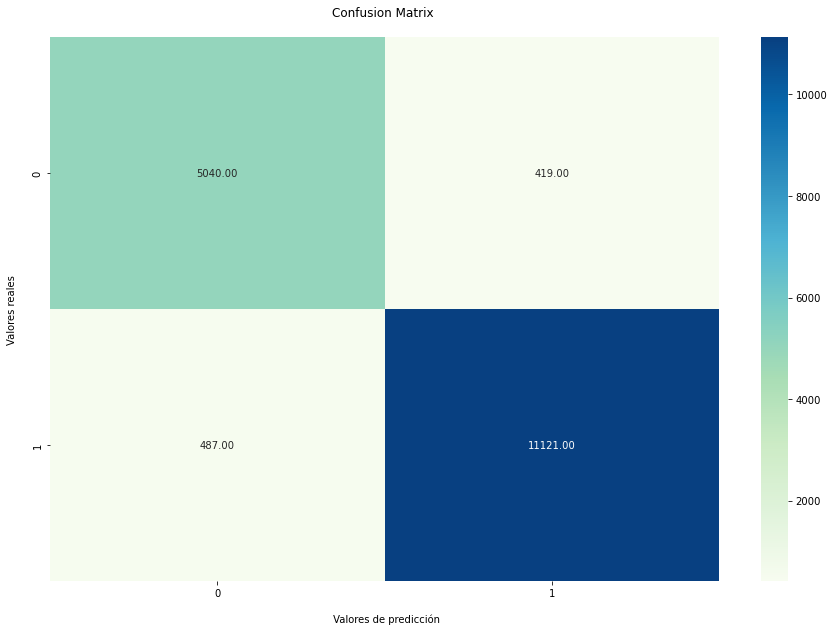

In [15]:
# Se evalúa el modelo con otras medidas de calidad y se presenta la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from matplotlib import*
from matplotlib.cm import register_cmap
import matplotlib.pyplot as plt 

MAE=metrics.mean_absolute_error(y_test_Clase, y_pred_Clase)
MSE=metrics.mean_squared_error(y_test_Clase, y_pred_Clase)
RMSE=np.sqrt(metrics.mean_squared_error(y_test_Clase, y_pred_Clase))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 

accuracyModeloBase=str(accuracy_score(y_test_Clase,y_pred_Clase))
print('Accuracy: ' + accuracyModeloBase) 

precision=precision_score(y_test_Clase,y_pred_Clase, average='weighted')#average one of [None, 'micro', 'macro', 'weighted']
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_test_Clase,y_pred_Clase, average='weighted')
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_test_Clase,y_pred_Clase, average='weighted')
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
print(confusion_matrix(y_test_Clase,y_pred_Clase))  

plt.figure(figsize=(15,10))
fx=sns.heatmap(confusion_matrix(y_test_Clase,y_pred_Clase), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Valores de predicción\n')
fx.set_ylabel('Valores reales\n');
plt.show()

In [16]:
# Se presenta la calidad de clasificación por categoría y a nivel general
from sklearn.metrics import classification_report
print(classification_report(y_test_Clase,y_pred_Clase))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      5459
           1       0.96      0.96      0.96     11608

    accuracy                           0.95     17067
   macro avg       0.94      0.94      0.94     17067
weighted avg       0.95      0.95      0.95     17067



In [17]:
#GUARDAR MODELO ENTRENADO
nombreArchivoModelo='modeloRNN'
guardarRNN(model,nombreArchivoModelo)

Guardando Red Neuronal en Archivo
Red Neuronal Grabada en Archivo


In [18]:
#CARGAR MODELO PARA COMPROBAR
nombreArchivoModelo='modeloRNN'
model=cargarRNN(nombreArchivoModelo) 
model.summary()

Red Neuronal Cargada desde Archivo
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 191, 128)          256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 191, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#EVALUAR POS_ACC Y NEG_ACC
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_test)):
    if x % 1000==0:
        print(x)
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 0)[0]
   
    if np.argmax(result) == np.argmax(Y_test[x]):
        if np.argmax(Y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

0
1000


<div id="prediccionNuevoElemento" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Fase 3: Clasificación de nuevos comentarios</h2> </div>

In [55]:
def cargarTokenizeryModeloRNN():
    tokenizer=cargarTokenizer('tokenizerRNN')
    #word_index = tokenizer.word_index
    # if word_index shorter then default value of vocab_size we'll save actual size
    #vocab_size=len(word_index)
    #print(vocab_size)
    #CARGAR MODELO
    nombreArchivoModelo='modeloRNN'
    model=cargarRNN(nombreArchivoModelo) 
    #model.summary()
    #help(model)
    return tokenizer, model

In [56]:
def predecirSentimiento(tokenizer,model,twt):
    num_Columnas=model.input_shape[1]
    #print(help(tokenizer))
    #twt = ['Regular atención']
    #vectorizing the tweet by the pre-fitted tokenizer instance
    twt = tokenizer.texts_to_sequences(twt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=num_Columnas, dtype='int32', value=0)

    #print(twt)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    print(sentiment)
    #print(np.argmax(sentiment))
    respuesta=""
    if(np.argmax(sentiment) == 0):
        prob = sentiment[0]
        respuesta = ("%s %.2f%%. %s" % ('No le gustó con certeza del', prob*100, "Muchas gracias por su comentario, lo tomaremos en cuenta para mejorar"))
        #print(respuesta)
    elif (np.argmax(sentiment) == 1):
        prob = sentiment[1]
        respuesta = ("%s %.2f%%. %s" % ('Le gustó con certeza del', prob*100, "Que bueno que le haya gustado, seguiremos mejorando para usted"))
        #print(respuesta)
    return respuesta

In [57]:
#Habilitar siguiente línea para cargar modelos guardados
tokenizer, model=cargarTokenizeryModeloRNN()
twt = ['Regular atención']
texto_respuesta=predecirSentimiento(tokenizer, model,[twt])
print(texto_respuesta)

Red Neuronal Cargada desde Archivo
1/1 - 1s - 532ms/epoch - 532ms/step
[0.08832632 0.9116737 ]
Le gustó con certeza del 91.17%. Que bueno que le haya gustado, seguiremos mejorando para usted


<div id="re-entrenamiento" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Fase 4: Actualizar conocimiento de la red con nuevo(s) comentario(s)</h2> </div>

<div style="color:#106ba3"><h3>Entrenamiento con nuevos datos: epoch por todos los comentarios (nuevos y antiguos)</h3> </div>

Se añade nuevos samples al conjunto de training, pero se partirá de los pesos anteriores guardados previamente. Cada nuevo epoch hará una pasada por todos los samples (comentarios nuevos y antiguos). Este proceso puede tardar.

In [18]:
#Nuevo(s) comentario(s) con etiqueta(s) en el conjunto de entrenamiento
data = ['Regular atención',0]
twt = [data[0]]
salida = data[1]
classes = np.array([0, 1])        
print(twt)
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=X.shape[1], dtype='int32', value=0)
print(twt)
#Salida en formato binario: similar a get_dummies
if(salida) == 0:# comentario negativo
    salida=[1,0]
else:#comentario positivo
    salida=[0,1]
X_train=np.vstack([X_train, twt])
Y_train=np.vstack([Y_train, salida])

batch_size = 256
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 1, use_multiprocessing= 'TRUE')

['Regular atención']
[[197]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 197]]
[1, 0]


<div style="color:#106ba3"><h3>Entrenamiento con un nuevo comentario: epoch solo por el nuevo comentario</h3> </div>

In [58]:
#Nuevo comentario con etiqueta
data = ['Regular atención',0] # se indica que es un comentario negativo
twt = [data[0]]
salida = data[1]
#Salida en formato binario: similar a get_dummies
if(salida) == 0:
    salida=[1,0]
else:
    salida=[0,1]
#print(salida)
#Lista a array
salida = np.array([salida])

num_Columnas=model.input_shape[1]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=num_Columnas, dtype='int32', value=0)
print(twt)

#Re-entrenamiento con nuevo sample
model.fit(twt, salida, epochs = 10, batch_size=1, verbose = 1, use_multiprocessing= 'TRUE')

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 196]]
Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 4.0104 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 285ms/step - loss: 1.3452 - accuracy: 0.0000e+00
Epoch 3/10


In [59]:
#Probar con el(los) comentario(s) recientemente aprendido(s)
twt = ['Regular atención']
texto_respuesta=predecirSentimiento(tokenizer, model,[twt])
print(texto_respuesta)

1/1 - 0s - 78ms/epoch - 78ms/step
[0.8347804  0.16521958]
No le gustó con certeza del 83.48%. Muchas gracias por su comentario, lo tomaremos en cuenta para mejorar


Ahora le red ha aprendido que un comentario de "atención regular" es un comentario negativo.

<div id="Conclusiones" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Conclusiones</h2> </div>

En esta práctica has aprendido a clasificar comentarios/sentimientos en buenos "1" y malos "0" sobre el servicio y platos de comida en restaurantes. El clasificador se desarrolló mediante procesamiento de lenguaje natural y una red neuronal recurrente de tipo LSTM. Has aprendido a entrenar o actualizar el conocimiento de la red neuronal con nuevos comentarios, sin necesidad de entrenar la red desde cero. Finalmente, has aprendido a presentar visualmente los resultados de calidad del modelo para una mejor comprensión.

<div id="Referencias-enlaces" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Referencias y enlaces</h2> </div>

[1] Dubiau, L., & Ale, J. M. (2013). Análisis de Sentimientos sobre un Corpus en Español: Experimentación con un Caso de Estudio. In XIV Argentine Symposium on Artificial Intelligence (ASAI)-JAIIO 42 (2013). Link: https://42jaiio.sadio.org.ar/proceedings/simposios/Trabajos/ASAI/04.pdf

[2] Bishop, C. M. (2006). Pattern recognition and machine learning. springer.

[3] P. Joshi. (2017). Artificial intelligence with python. Packt Publishing Ltd.

[4] S. Raschka, V. Mirjalili. (2007). Python Machine Learning, Packt Publishing Ltd.

[5] Martinez, J. (2020). Precision, Recall, F1, Accuracy en clasificación [IArtificial.net]. Recuperado de https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/

**Enlaces de documentación de scikit-learn y matplotlib:**

https://keras.io/api

https://scikit-learn.org/stable/modules/cross_validation.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score